In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os
import glob
import sys


# Importing callbacks and data augmentation utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import  Adam

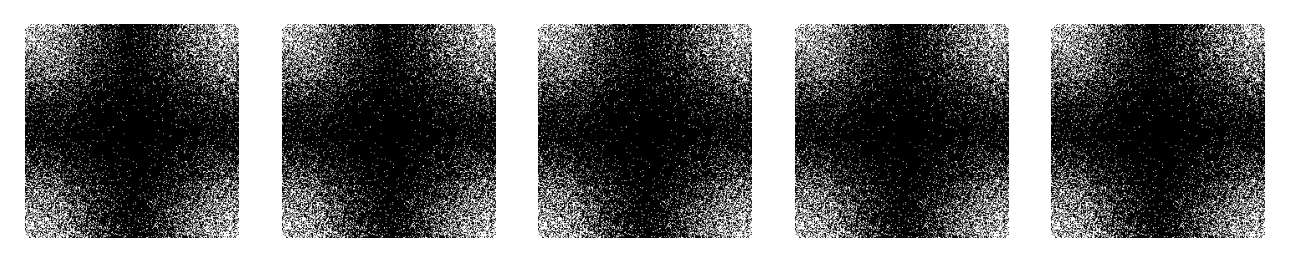

Sampling: 0.1999969482421875
Number of 1s: 26214 (19.99969482%)
Number of 0s: 104858 (80.00030518%)
Min 0
Max 1
data range 1
var_sampling_mask (100, 256, 256, 2) uint8 <class 'numpy.ndarray'>
var_sampling_mask[0] (256, 256, 2) uint8 <class 'numpy.ndarray'>


In [2]:
# Loading sampling patterns. Notice that here we are using uncentred k-space

var_sampling_mask=np.load('./Data/var_sampling_mask.npy')
var_sampling_mask = np.concatenate((var_sampling_mask[:,:,:,np.newaxis],var_sampling_mask[:,:,:,np.newaxis]),\
                                          axis = -1)


# White pixels are retrospectively discarded
plt.figure(dpi = 250)
for ii in range(5):
    plt.subplot(1,5,ii+1)
    plt.imshow(var_sampling_mask[ii*10,:,:,0],cmap = "gray")
    plt.axis("off")
plt.show()

print("Sampling:", 1.0*var_sampling_mask.sum()/var_sampling_mask.size)
num_zeros = np.sum(var_sampling_mask[0] == 0)
num_ones = np.sum(var_sampling_mask[0] == 1)
# Print results
total_pixels = var_sampling_mask[0].size

# Calculate percentages
ones_percentage = (num_ones / total_pixels) * 100
zeros_percentage = (num_zeros / total_pixels) * 100

print(f"Number of 1s: {num_ones} ({ones_percentage:.8f}%)")
print(f"Number of 0s: {num_zeros} ({zeros_percentage:.8f}%)")
print("Min",var_sampling_mask[0].min())
print("Max",var_sampling_mask[0].max())
print("data range",var_sampling_mask[0].max()-var_sampling_mask[0].min())
print("var_sampling_mask",var_sampling_mask.shape,var_sampling_mask.dtype,type(var_sampling_mask))
print("var_sampling_mask[0]",var_sampling_mask[0].shape,var_sampling_mask[0].dtype,type(var_sampling_mask[0]))

(1,) <U37 <class 'numpy.ndarray'>


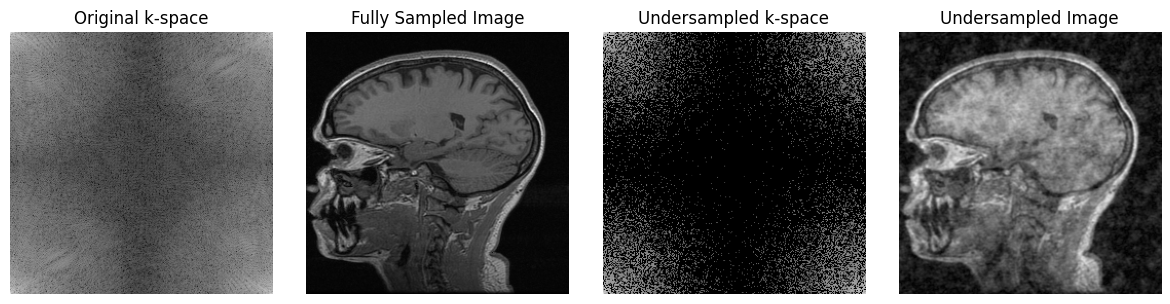

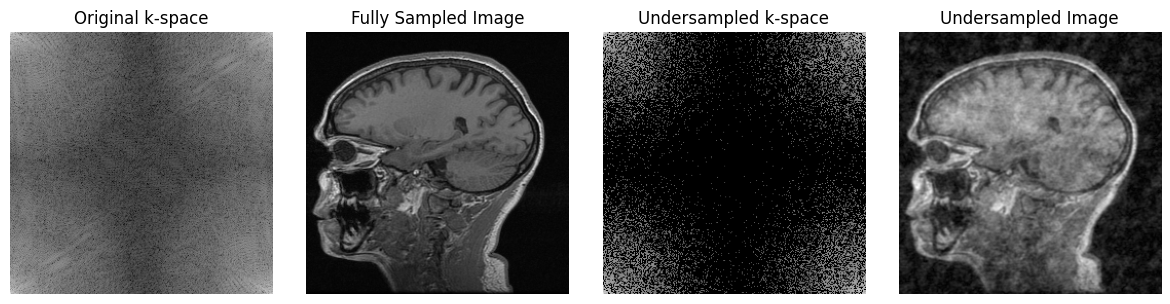

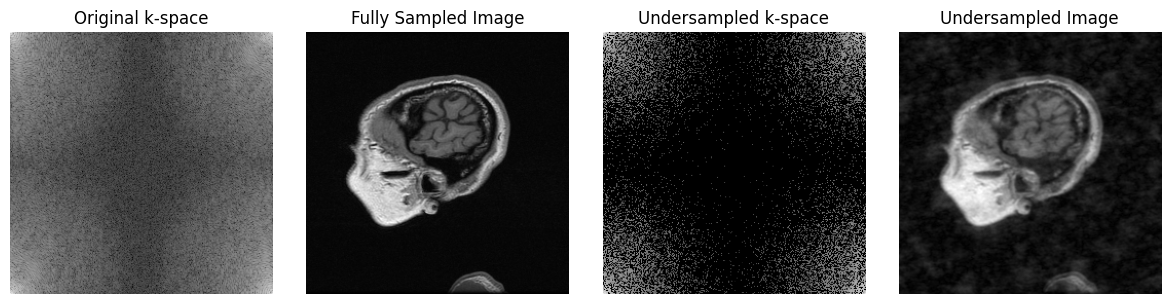

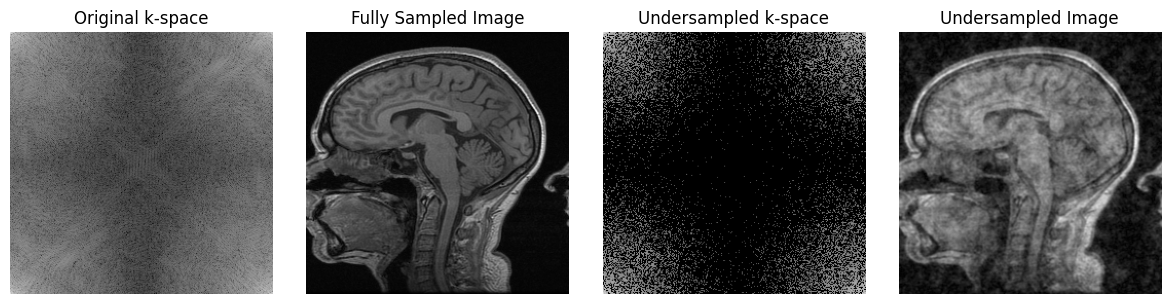

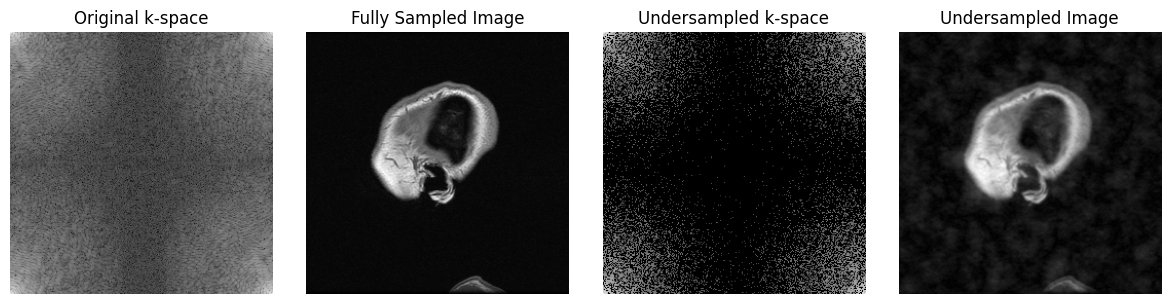

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob

# PARAMETERS
H, W = 256, 256  # Image dimensions
channels = 2  # 0 -> real, 1 -> imaginary
norm = np.sqrt(H * W)

# Load k-space training files
train_path_single = "D:/cc-359/Train/e13991s3_P01536.7.npy"
kspace_files_train_single = np.asarray(glob.glob(train_path_single))
print(kspace_files_train_single.shape,kspace_files_train_single.dtype,type(kspace_files_train_single))
# Get number of training samples
ntrain_single = sum(np.load(f).shape[0] for f in kspace_files_train_single)
if ntrain_single == 0:
    raise ValueError("No training data found!")

# Allocate memory for fully sampled image dataset
rec_train_single = np.zeros((ntrain_single, H, W, 2))

# Load k-space data and apply inverse FFT
aux_counter = 0
for f in kspace_files_train_single:
    aux_kspace = np.load(f) / norm  # Normalize
    aux = aux_kspace.shape[0]
    aux2 = np.fft.ifft2(aux_kspace[:, :, :, 0] + 1j * aux_kspace[:, :, :, 1])  # IFFT to get fully sampled image
    rec_train_single[aux_counter:aux_counter + aux, :, :, 0] = aux2.real
    rec_train_single[aux_counter:aux_counter + aux, :, :, 1] = aux2.imag
    aux_counter += aux

# Shuffle training data
indexes = np.arange(ntrain_single, dtype=int)
np.random.shuffle(indexes)
rec_train_single = rec_train_single[indexes]

# Display visualizations
for i in range(min(ntrain_single, 5)):  # Show a limited number of samples (e.g., 5)
    # Get fully sampled image
    image_full = np.abs(rec_train_single[i, :, :, 0] + 1j * rec_train_single[i, :, :, 1])

    # Get original k-space from fully sampled image
    kspace_full = np.fft.fft2(rec_train_single[i, :, :, 0] + 1j * rec_train_single[i, :, :, 1])
    
    # Apply undersampling mask
    mask_idx = np.random.choice(var_sampling_mask.shape[0], 1, replace=False)[0]  # Random mask selection
    mask = var_sampling_mask[mask_idx]
    kspace_under = kspace_full * mask[:, :, 0]  # Apply mask to k-space

    # Get undersampled image
    image_under = np.abs(np.fft.ifft2(kspace_under))

    # Create figure
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    
    axs[0].imshow(np.log(1 + np.abs(kspace_full)), cmap="gray")
    axs[0].set_title("Original k-space")
    axs[0].axis("off")

    axs[1].imshow(image_full, cmap="gray")
    axs[1].set_title("Fully Sampled Image")
    axs[1].axis("off")

    axs[2].imshow(np.log(1 + np.abs(kspace_under)), cmap="gray")
    axs[2].set_title("Undersampled k-space")
    axs[2].axis("off")

    axs[3].imshow(image_under, cmap="gray")
    axs[3].set_title("Undersampled Image")
    axs[3].axis("off")

    plt.tight_layout()
    plt.show()  # Display the plot instead of saving to PDF


Number of samples: 170
len 170
undersampled_kspace (256, 256, 2)
var_sampling_mask (100, 256, 256, 2)


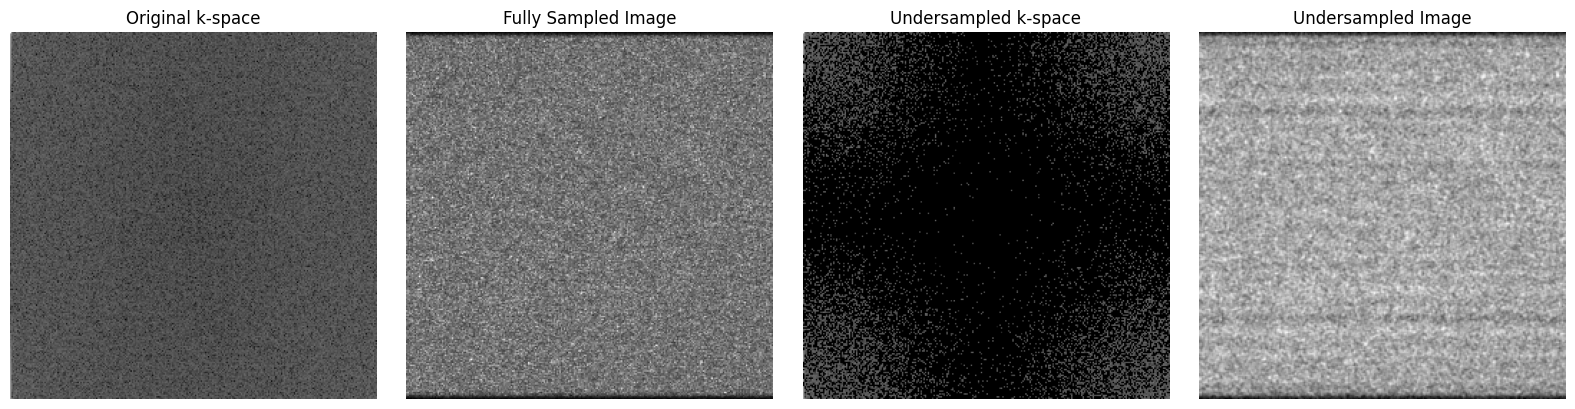

undersampled_kspace (256, 256, 2)
var_sampling_mask (100, 256, 256, 2)


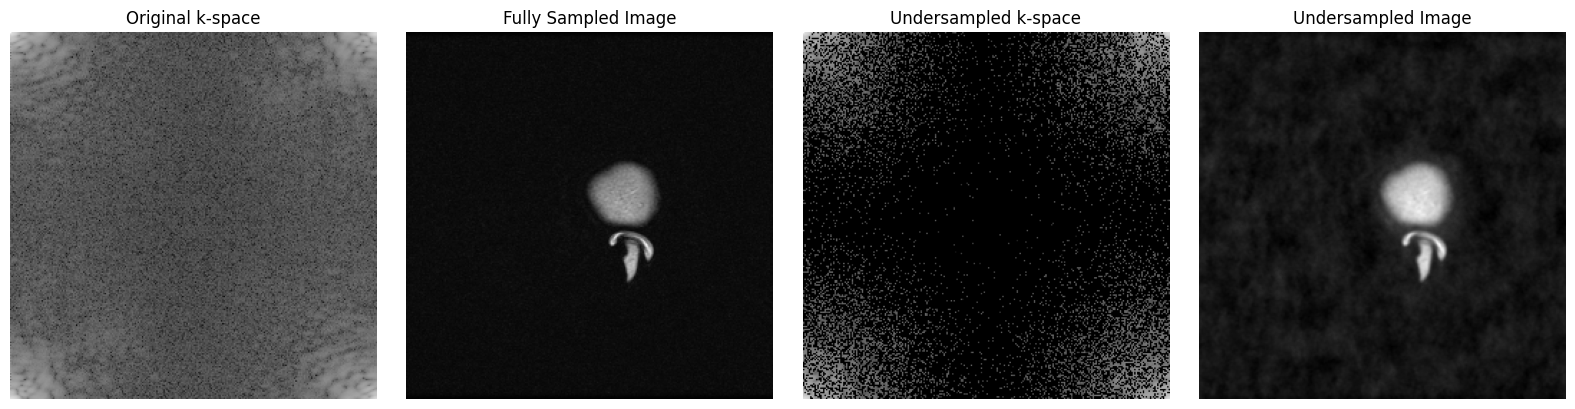

undersampled_kspace (256, 256, 2)
var_sampling_mask (100, 256, 256, 2)


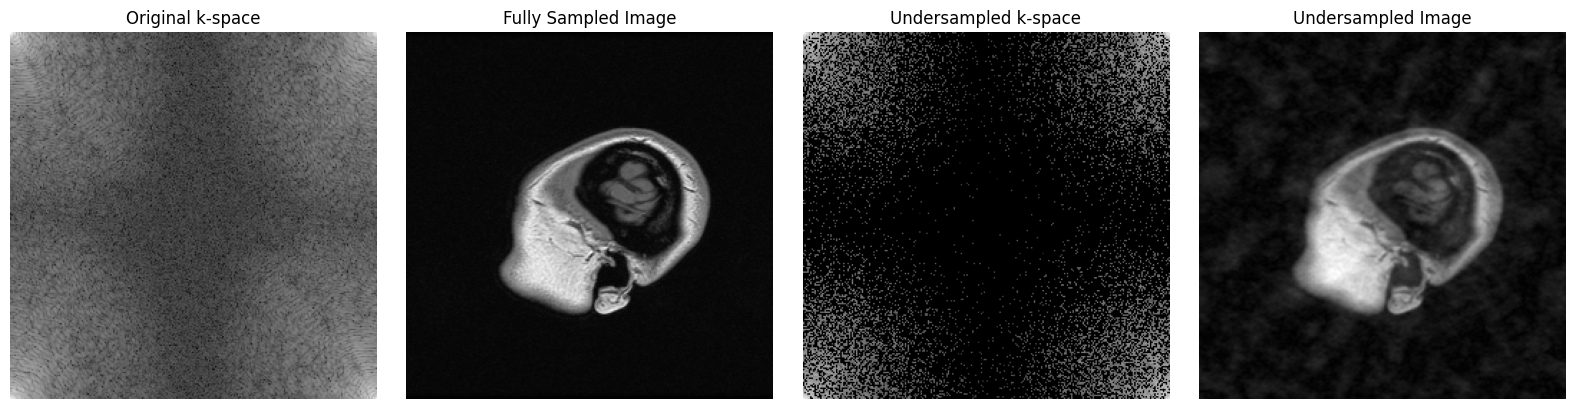

undersampled_kspace (256, 256, 2)
var_sampling_mask (100, 256, 256, 2)


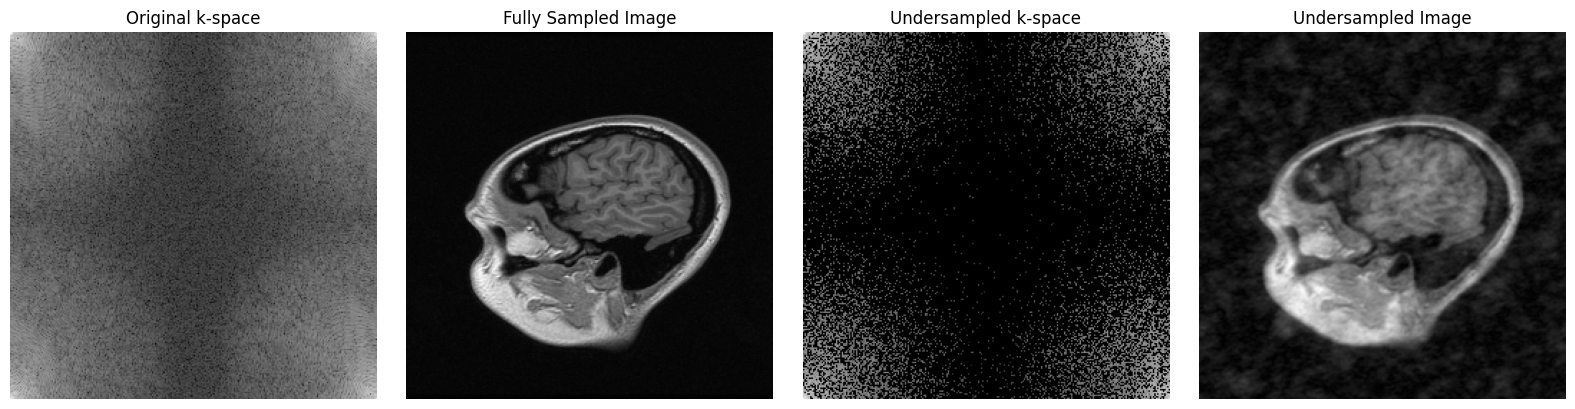

undersampled_kspace (256, 256, 2)
var_sampling_mask (100, 256, 256, 2)


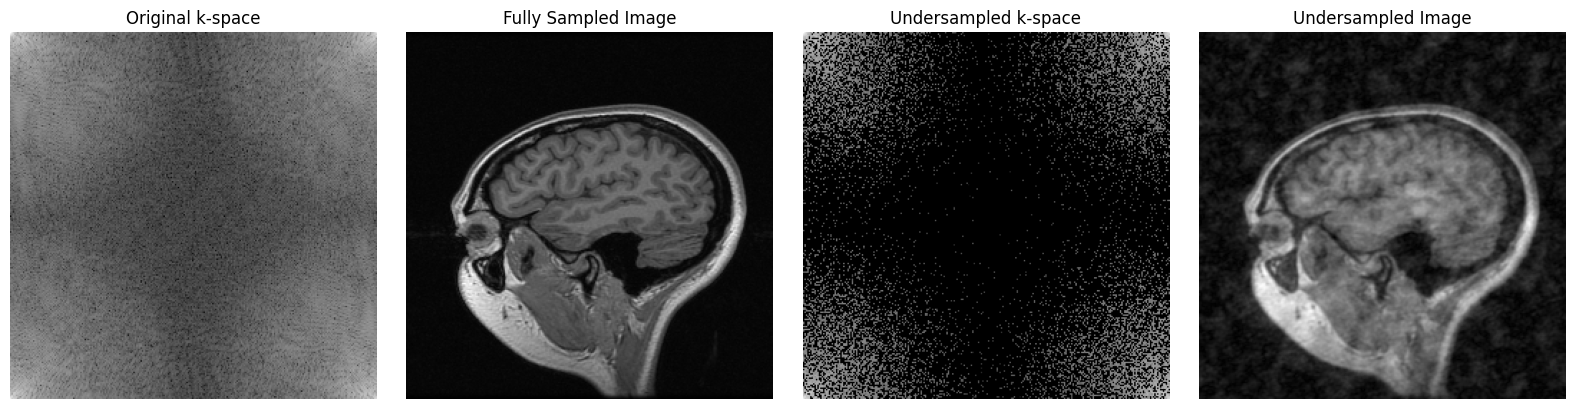

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import glob

# Validation set path
val_path_single = "D:/cc-359/Val/e14258s3_P76800.7.npy"
kspace_files_val_single = np.asarray(glob.glob(val_path_single))

# Count number of samples
nval_single = sum(np.load(f).shape[0] for f in kspace_files_val_single)


# Load validation data
kspace_val_single = np.zeros((nval_single, H, W, 2))
rec_val_single = np.zeros((nval_single, H, W, 2))
aux_counter = 0

for f in kspace_files_val_single:
    aux_kspace = np.load(f) / norm
    aux = aux_kspace.shape[0]
    kspace_val_single[aux_counter:aux_counter+aux] = aux_kspace
    aux2 = np.fft.ifft2(aux_kspace[:, :, :, 0] + 1j * aux_kspace[:, :, :, 1])
    rec_val_single[aux_counter:aux_counter+aux, :, :, 0] = aux2.real
    rec_val_single[aux_counter:aux_counter+aux, :, :, 1] = aux2.imag
    aux_counter += aux

print("Number of samples:", kspace_val_single.shape[0])

indexes = np.random.choice(var_sampling_mask.shape[0], kspace_val_single.shape[0], replace=True)
print("len",len(indexes))
val_var_sampling_mask = var_sampling_mask[indexes]
#kspace_under = kspace_full * mask[:, :, 0]
# Display images in Jupyter Notebook
num_samples_to_display = 5  # Adjust as needed
for i in range(min(num_samples_to_display, kspace_val_single.shape[0])):
    original_kspace = kspace_val_single[i*10]  # Original k-space
    fully_sampled_image = np.fft.ifft2(original_kspace[:, :, 0] + 1j * original_kspace[:, :, 1])

    # Apply undersampling
    undersampled_kspace = np.copy(original_kspace)
    print("undersampled_kspace",undersampled_kspace.shape)
    print("var_sampling_mask",var_sampling_mask.shape)
    undersampled_kspace=undersampled_kspace*var_sampling_mask[0,:,:,:]
    undersampled_image = np.fft.ifft2(undersampled_kspace[:, :, 0] + 1j * undersampled_kspace[:, :, 1])

    # Create figure
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    axs[0].imshow(np.log(1 + np.abs(original_kspace[:, :, 0] + 1j * original_kspace[:, :, 1])), cmap='gray')
    axs[0].set_title("Original k-space")
    axs[0].axis("off")

    axs[1].imshow(np.abs(fully_sampled_image), cmap='gray')
    axs[1].set_title("Fully Sampled Image")
    axs[1].axis("off")

    axs[2].imshow(np.log(1 + np.abs(undersampled_kspace[:, :, 0] + 1j * undersampled_kspace[:, :, 1])), cmap='gray')
    axs[2].set_title("Undersampled k-space")
    axs[2].axis("off")

    axs[3].imshow(np.abs(undersampled_image), cmap='gray')
    axs[3].set_title("Undersampled Image")
    axs[3].axis("off")

    plt.tight_layout()
    plt.show()  # Display in Jupyter Notebook


In [5]:
## PARAMETERS
H,W = 256,256 # Training image dimensions
channels = 2 # complex data 0-> real; 1-> imaginary
norm = np.sqrt(H*W)

# Train Set 
train_path = "D:/cc-359/Train/*.npy"
kspace_files_train = np.asarray(glob.glob(train_path))

# Validation set
val_path = "D:/cc-359/Val/*.npy"
kspace_files_val = np.asarray(glob.glob(val_path))

indexes = np.arange(kspace_files_train.size,dtype = int)
np.random.shuffle(indexes)
kspace_files_train = kspace_files_train[indexes]


print(kspace_files_train[-1])
print(len(kspace_files_train))

print(kspace_files_val[-1])
print(len(kspace_files_val))

D:/cc-359/Train\e14091s3_P67584.7.npy
25
D:/cc-359/Val\e14553s5_P44544.7.npy
10


In [6]:
# Get number of samples
ntrain = 0
for ii in range(len(kspace_files_train)):
    ntrain += np.load(kspace_files_train[ii]).shape[0] 

# Load train data    
rec_train = np.zeros((ntrain,H,W,2))

aux_counter = 0
for ii in range(len(kspace_files_train)):
     aux_kspace = np.load(kspace_files_train[ii])/norm
     aux = int(aux_kspace.shape[0])
     aux2 = np.fft.ifft2(aux_kspace[:,:,:,0]+\
                         1j*aux_kspace[:,:,:,1])
     rec_train[aux_counter:aux_counter+aux,:,:,0] = aux2.real
     rec_train[aux_counter:aux_counter+aux,:,:,1] = aux2.imag
     aux_counter+=aux

# Shuffle training    
indexes = np.arange(rec_train.shape[0],dtype = int)
np.random.shuffle(indexes)
rec_train = rec_train[indexes]
print("Number of training samples", rec_train.shape[0])

Number of training samples 4254


In [7]:
import numpy as np

def data_generator(rec_train, var_sampling_mask, batch_size=8):
    """
    Data generator that processes MRI images like in the visualization code.
    It yields (k-space, mask) as input and fully sampled image as output.
    
    Parameters:
        rec_train (numpy array): Fully sampled complex-valued images of shape (N, H, W, 2)
        var_sampling_mask (numpy array): Undersampling masks of shape (num_masks, H, W, 2)
        batch_size (int): Number of samples per batch
        
    Yields:
        (kspace_under, mask_batch), rec_complex
    """
    n_samples = rec_train.shape[0]
    while True:
        indexes = np.random.choice(n_samples, batch_size, replace=False)
        batch_real = rec_train[indexes, :, :, 0]
        batch_imag = rec_train[indexes, :, :, 1]

        # Convert images to k-space
        kspace = np.fft.fft2(batch_real + 1j * batch_imag)

        # Allocate space for k-space storage
        kspace2 = np.zeros((batch_size, kspace.shape[1], kspace.shape[2], 2), dtype=np.float32)
        kspace2[:, :, :, 0] = kspace.real
        kspace2[:, :, :, 1] = kspace.imag

        # Select random undersampling masks
        mask_indexes = np.random.choice(var_sampling_mask.shape[0], batch_size, replace=False)
        masks_batch = var_sampling_mask[mask_indexes]

        # Apply undersampling masks to k-space
        kspace2 *= masks_batch

        # Fully sampled complex-valued image
        rec_complex = np.zeros((batch_size, batch_real.shape[1], batch_real.shape[2], 2), dtype=np.float32)
        rec_complex[:, :, :, 0] = batch_real
        rec_complex[:, :, :, 1] = batch_imag

        yield ([kspace2, masks_batch.astype(np.float32)], [rec_complex])


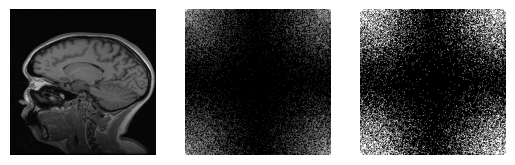

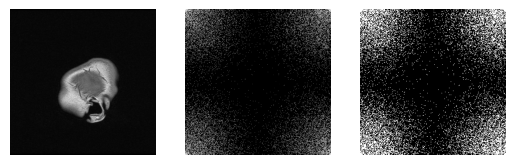

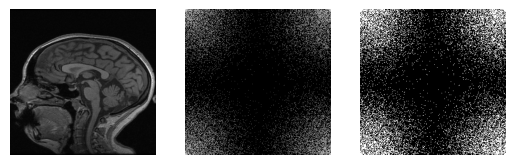

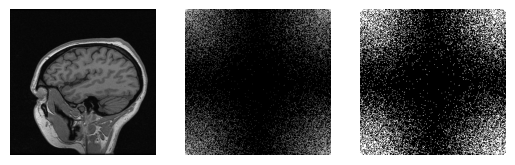

In [8]:
batch_size = 8
data_gen = data_generator(rec_train, var_sampling_mask, batch_size=batch_size)
# Dispaly sample data augmentation
counter = 0
for ii in data_gen:
    plt.figure()
    plt.subplot(131)
    plt.imshow(np.abs(ii[1][0][4,:,:,0]+1j*ii[1][0][4,:,:,0]),cmap = 'gray')
    plt.axis("off")
    plt.subplot(132)
    plt.imshow(np.log(1+np.abs(ii[0][0][4,:,:,0] + 1j*ii[0][0][4,:,:,1])),cmap = 'gray')
    plt.axis("off")
    plt.subplot(133)
    plt.imshow(ii[0][0][4,:,:,0].astype(bool),cmap = 'gray')
    plt.axis("off")
    plt.show()
    counter+=1
    if counter > 3:
        break

In [9]:
# Get number of samples
# Validation set
val_path = "D:/cc-359/Val/*.npy"
kspace_files_val = np.asarray(glob.glob(val_path))

nval = 0
for ii in range(len(kspace_files_val)):
    nval += (np.load(kspace_files_val[ii]).shape[0] )

# Load Validation data
kspace_val = np.zeros((nval,H,W,2))
rec_val = np.zeros((nval,H,W,2))
aux_counter = 0
for ii in range(len(kspace_files_val)):
    aux_kspace = np.load(kspace_files_val[ii])/norm
    aux = int(aux_kspace.shape[0])
    kspace_val[aux_counter:aux_counter+aux] = aux_kspace
    aux2 = np.fft.ifft2(aux_kspace[:,:,:,0]+1j*aux_kspace[:,:,:,1])
    rec_val[aux_counter:aux_counter+aux,:,:,0] = aux2.real
    rec_val[aux_counter:aux_counter+aux,:,:,1] = aux2.imag
    aux_counter+=aux

print("Number of samples", kspace_val.shape[0])

Number of samples 1700


In [10]:
indexes = np.random.choice(np.arange(var_sampling_mask.shape[0], dtype=int), kspace_val.shape[0], replace=True)
print(len(indexes))
val_var_sampling_mask = var_sampling_mask[indexes]
undersampled_kspace = np.copy(kspace_val)
print("undersampled_kspace",undersampled_kspace.shape)
print("val_var_sampling_mask",val_var_sampling_mask.shape)
undersampled_kspace=undersampled_kspace*val_var_sampling_mask
#undersampled_kspace[val_var_sampling_mask[i] == 0] = 0
#kspace_val[val_var_sampling_mask] = 0

1700
undersampled_kspace (1700, 256, 256, 2)
val_var_sampling_mask (1700, 256, 256, 2)


In [11]:
import matplotlib.pyplot as plt
import tensorflow as tf

class LiveLossPlot(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.losses = []
        self.val_losses = []
        self.fig, self.ax = plt.subplots()
        plt.ion()  # Turn on interactive mode

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.losses.append(logs.get("loss"))
        self.val_losses.append(logs.get("val_loss"))

        # Clear the previous plot and redraw
        self.ax.clear()
        self.ax.plot(self.losses, label="Training Loss", marker='o', linestyle='-')
        self.ax.plot(self.val_losses, label="Validation Loss", marker='o', linestyle='-')
        self.ax.legend()
        self.ax.set_xlabel("Epochs")
        self.ax.set_ylabel("Loss")
        self.ax.set_title(f"Epoch {epoch+1}: Loss={logs.get('loss'):.4f}, Val Loss={logs.get('val_loss'):.4f}")

        plt.draw()
        plt.pause(0.001)  # Small pause to allow updates
        self.fig.canvas.flush_events()  # Force Matplotlib to refresh

    def on_train_end(self, logs=None):
        plt.ioff()  # Disable interactive mode after training
        plt.show()


In [12]:
epochs = 100
batch_size=4

model_name = "./Saved_Models/spatial_attentio1.hdf5"

# Early stopping callback to shut down training after
# 5 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

# Checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                         monitor='val_loss',verbose=0,\
                         save_best_only=True, save_weights_only = True)

In [13]:
import tensorflow as tf
import os

# Define the log directory
log_dir = "./logs/training_logs_final"

# Create the TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [14]:
%run ./Modules/model_attention1.ipynb


In [15]:
#%run ./Modules/data_generator.ipynb
# Training our model
model = deep_cascade_flat_unrolled("ikikii", H, W)
opt = Adam(learning_rate = 1e-3,decay = 1e-4)
model.compile(loss = 'mse',optimizer=opt)
hist = model.fit(
    data_gen,
    epochs=epochs,
    steps_per_epoch=rec_train.shape[0] // batch_size,
    verbose=1,
    validation_data=([undersampled_kspace, val_var_sampling_mask], [rec_val]),
    callbacks=[checkpoint, earlyStopping, tensorboard_callback]  # Add TensorBoard callback
)

Epoch 1/100
1063/1063 [==============================] - 554s 501ms/step - loss: 0.0713 - val_loss: 0.0450
Epoch 2/100
1063/1063 [==============================] - 532s 500ms/step - loss: 0.0462 - val_loss: 0.0424
Epoch 3/100
1063/1063 [==============================] - 533s 501ms/step - loss: 0.0450 - val_loss: 0.0403
Epoch 4/100
1063/1063 [==============================] - 531s 499ms/step - loss: 0.0424 - val_loss: 0.0400
Epoch 5/100
1063/1063 [==============================] - 531s 499ms/step - loss: 0.0415 - val_loss: 0.0389
Epoch 6/100
1063/1063 [==============================] - 531s 499ms/step - loss: 0.0408 - val_loss: 0.0382
Epoch 7/100
1063/1063 [==============================] - 531s 499ms/step - loss: 0.0401 - val_loss: 0.0380
Epoch 8/100
1063/1063 [==============================] - 531s 499ms/step - loss: 0.0396 - val_loss: 0.0374
Epoch 9/100
1063/1063 [==============================] - 531s 499ms/step - loss: 0.0393 - val_loss: 0.0375
Epoch 10/100
1063/1063 [=============